In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import pylab as plt
import glob
import os
import scipy.integrate as inte
import scipy.special as special
import scipy.interpolate as interp

In [10]:
import stephane.display.graphes as graphes
import stephane.tools.Smath as smath
#import sympy #symoblic python
import mpmath as math
import cv2
import glob
import csv
import os
import pickle

In [7]:
savefolder = 'Results_Temperature/'
if not os.path.isdir(savefolder):
    os.makedirs(savefolder)

In [11]:
#get start time, duration of recording
#folder = 'First_Test_round_table'#/media/turbots/DATA/thiou/labshared2/Windveil/NedFacades/recaps/'
filename = glob.glob('*.pickle')[0]

with open(filename, 'rb') as handle:
    data = pickle.load(handle)

In [21]:
data[49].keys()

dict_keys(['T', 'level'])

dict_keys(['time', 8, 20, 27, 30, 49, 65])


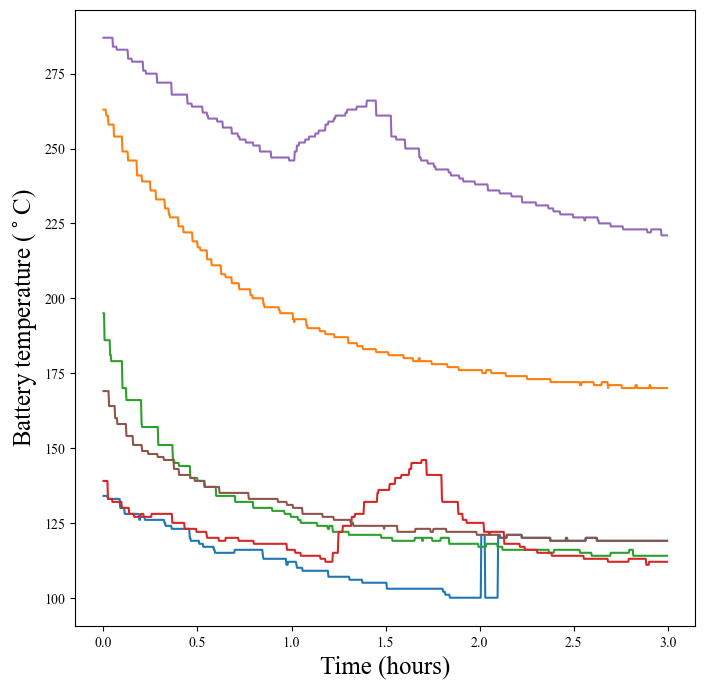

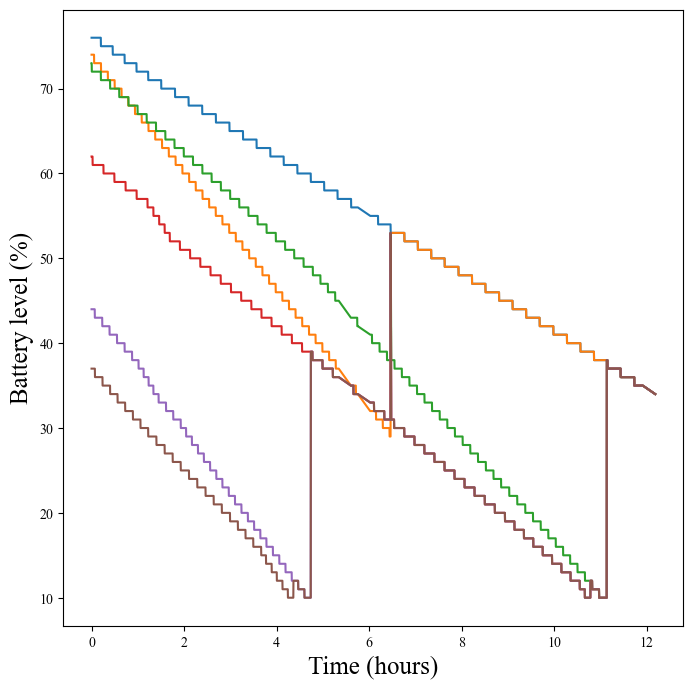

In [25]:
print(data.keys())

phonelist = [8, 20, 27, 30, 49, 65]

fig,ax = plt.subplots(figsize=(8,8))

for phone in phonelist:
    tab = np.asarray(data[phone]['T'])
    time = tab[:,0]
    
    indices = time/3600<3
    time = time[indices]
    T  = tab[indices,1]

    ax.plot(time/3600,T)
#    print(data[phone]['T'].keys())
    figs = graphes.legende('Time (hours)','Battery temperature ($^\circ$C)','')
    

fig,ax = plt.subplots(figsize=(8,8))

for phone in phonelist:
    tab = np.asarray(data[phone]['level'])
    time = tab[:,0]
    batt  = tab[:,1]

    ax.plot(time/3600,batt)
#    print(data[phone]['T'].keys())
    figs.update(graphes.legende('Time (hours)','Battery level (%)',''))
    
graphes.save_figs(figs,savedir=savefolder)

In [15]:
np.asarray(data[phone]['T'])

array([[    0,   169],
       [   11,   169],
       [   21,   169],
       ...,
       [42884,   109],
       [42894,   109],
       [43856,   109]])

In [111]:
starts = np.asarray([float(data['time'][i]['raw'][1][2]) for i in range(1,34)])
stops = np.asarray([float(data['time'][i]['raw'][2][2]) for i in range(1,34)])

figure already exists


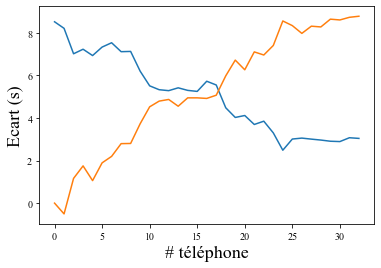

In [112]:
Dt = starts-starts[0]
for num in data['time'].keys():
    data['time'][num]['dt']= Dt[num-1]
    #print(num,Dt[num-1])
plt.plot(stops-starts-120)
plt.plot(starts-starts[0])

figs = graphes.legende('# téléphone','Ecart (s)','')
graphes.save_figs(figs,savedir=savefolder)

In [113]:
# look at correlation along z
#get start time, duration of recording
folder = 'First_Test_round_table'#/media/turbots/DATA/thiou/labshared2/Windveil/NedFacades/recaps/'
csv_timelist = glob.glob(folder+'/*/Raw data.csv')

#print(csv_timelist)
#data = {}
key = 'xyz'

keys = ['t','ax','ay','az']

data[key]={}
for filename in csv_timelist:
    rows = []
    num = int(filename.split('_')[-1].split('/')[0])-100
    #print(num)
    data[key][num]={}
    with open(filename) as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for i,row in enumerate(spamreader):
            rows.append(row)
            #print(', '.join(row))
            for j,k in enumerate(keys):
                if i==0:
                    data[key][num][k]=[]
                else:
                    data[key][num][k].append(float(row[j]))
                
#filename = glob.glob(folder+'*.csv')[0]

figure already exists


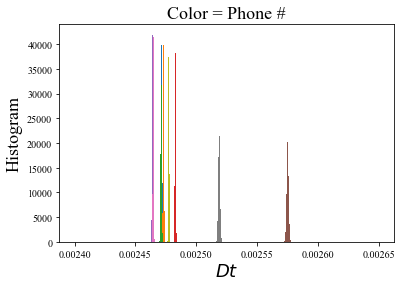

In [117]:
for num in range(1,10):
    fig = plt.hist(np.diff(data[key][num]['t']),np.linspace(0.0024,0.00265,300))
figs = graphes.legende('$Dt$','Histogram','Color = Phone #')
graphes.save_figs(figs,savedir=savefolder)

figure already exists


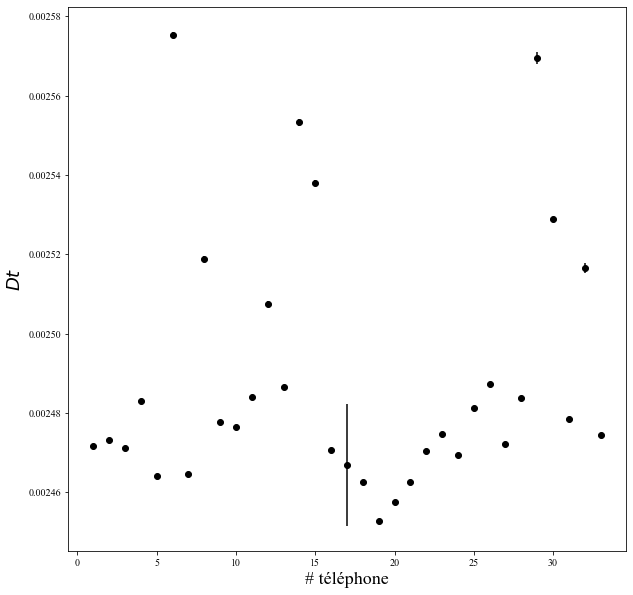

In [120]:
Ft,Ft_std = [],[]
tellist = range(1,34)
for num in tellist:
    ft = np.mean(np.diff(data[key][num]['t']))
    ft_std = np.std(np.diff(data[key][num]['t']))
    Ft.append(ft)
    Ft_std.append(ft_std)

fig,ax = plt.subplots(figsize=(10,10))
plt.errorbar(tellist,Ft,np.asarray(Ft_std),marker='o',color='k',ls=' ')
figs = graphes.legende('# téléphone','$Dt$','')
graphes.save_figs(figs,savedir=savefolder)

In [121]:
(np.max(Ft)-np.min(Ft))/np.mean(Ft)

0.04923493725112989

In [122]:
dt = np.mean(Ft)
print(dt)
f={}
for num in tellist:
    f[num] = interp.interp1d(data[key][num]['t']+data['time'][num]['dt'],data[key][num]['az'])

0.0024886492550220012


In [123]:
minT = []
maxT = []
for num in tellist:
    t = data[key][num]['t']+data['time'][num]['dt']
    minT.append(t[0])
    maxT.append(t[-1])

mint = np.max(minT)
maxt = np.min(maxT)

print(maxt-mint)
ti = np.arange(mint,maxt,dt)
N = len(ti)
print()

118.86088235756871



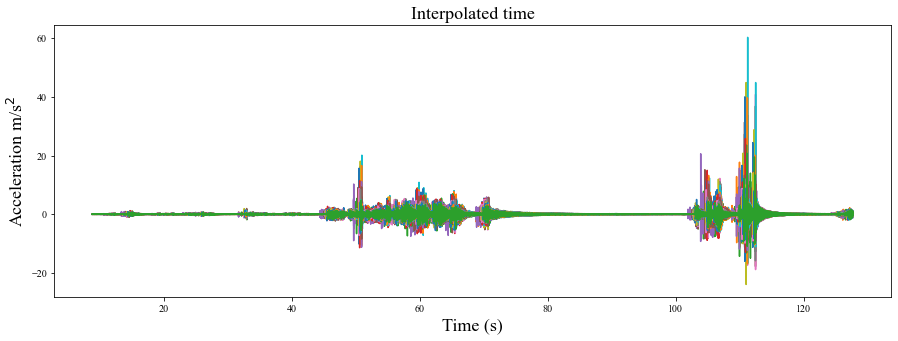

In [124]:
Z = np.zeros((len(tellist),N))
for num in tellist:
    Z[num-1,:] = f[num](ti)
    Z[num-1,:] = Z[num-1,:] - np.mean(Z[num-1,:])

fig,ax = plt.subplots(figsize=(15,5))
for num in tellist:
    ax.plot(ti,Z[num-1,:])
    graphes.legende('Time (s)','Acceleration m/s$^2$','Interpolated time')

(-1.0, 1.0, -1.0, 1.0)

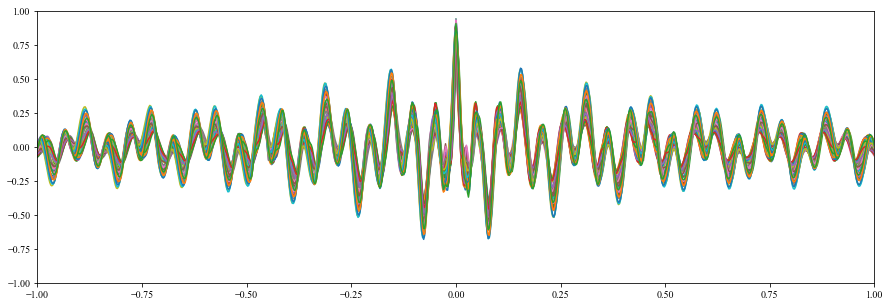

In [127]:
import scipy.signal as sig

fig,ax = plt.subplots(figsize=(15,5))

j=1
n = len(tellist)
Dt2 = np.zeros(n)
for num in tellist:
    nump = np.mod(num+j-1,n)+1
    numm = np.mod(num+j-3,n)+1

    #print(num,num2)
    
    Cp = np.asarray(sig.correlate(Z[num-1,:],Z[nump-1,:],mode='same'))
    Norm = np.sqrt(np.sum(Z[num-1,:]**2)*np.sum(Z[nump-1,:]**2))
    Cp = Cp/Norm
    
    Cm = np.asarray(sig.correlate(Z[num-1,:],Z[nump-1,:],mode='same'))
    Norm = np.sqrt(np.sum(Z[num-1,:]**2)*np.sum(Z[nump-1,:]**2))
    Cm/Norm
    
    lag = ti-np.mean(ti)
    k = np.argmax(C)
    Dtp[num-1] = lag[k]
    Dtm[num-1] = lag[k]
    
    ax.plot(lag-Dt2[num-1],C/Norm)
    
plt.axis([-1,1,-1,1])

(-1.0, 1.0, -1.0, 1.0)

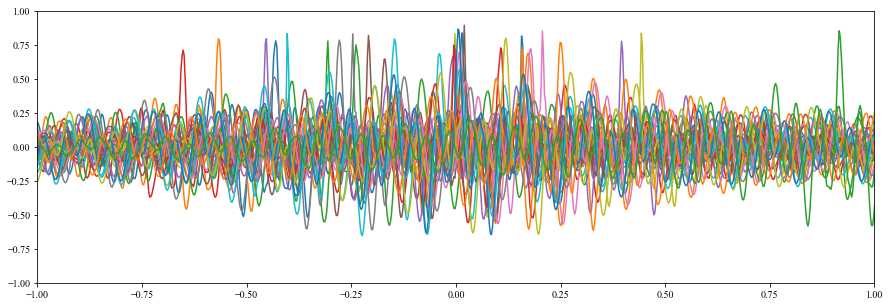

In [128]:
import scipy.signal as sig

fig,ax = plt.subplots(figsize=(15,5))

j=2
n = len(tellist)
#Dt2 = []
for num in tellist:
    num2 = np.mod(num+j-1,n)+1
    #print(num,num2)
    
    C = np.asarray(sig.correlate(Z[num-1,:],Z[num2-1,:],mode='same'))
    Norm = np.sqrt(np.sum(Z[num-1,:]**2)*np.sum(Z[num2-1,:]**2))
    lag = ti-np.mean(ti)
    k = np.argmax(C)
    #Dt2.append(lag[k])
    ax.plot(lag-Dt2[num-1],C/Norm)
    
plt.axis([-1,1,-1,1])

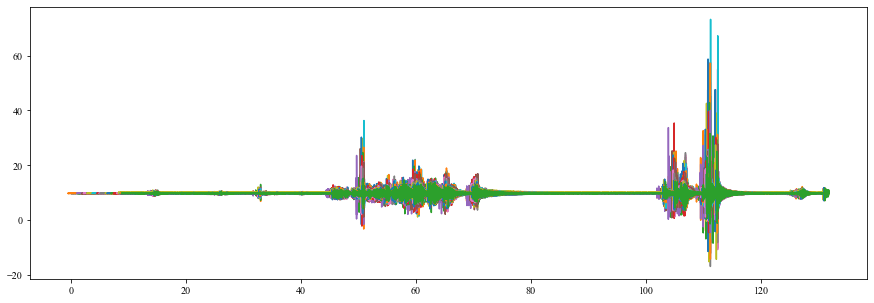

In [18]:
fig,ax = plt.subplots(figsize=(15,5))
C = np.zeros()
for i in range(1,34):
    for j in range(1,34):
        C[i,j] = 
        
    ax.plot(data[key][num]['t']+data['time'][num]['dt'],data[key][num]['az'])